# Ethogram analysis

In this notebook we will use the DLC tracking to categorize behaviour from the object space task in different states. States definition uses the following information.

1. Navigation : animal is far away from the object (circle defined as 200px radious) and running at speed > 2cm/s
2. Resting    : animal is far away from the object circle defined as 200px radious and speed < 2cm/s
3. Exploring  : animal is close to object (with a big radius of 200px) and is inspecting it, or it is at a closer distance (radius < 100 px) 
4. Inspection : animal is looking at the object (angle between head direction and object direcction < 45')

Exploting and inspection can be divided in the different objects the animal is looking at, given by the positions of the objects.

1. LL : lower left object
2. LR : Lower right object
3. UL : uper left object
4. UR : uper right object

Now, we will define :

1. Resting outside arena.
2. Resting inside arena : far away from object and speed < 50px/s
3. Navigation : far way from object and speed > 50px/s and the animal is not looking at the object.
4. Running towards object: speed is >50px/s and animal is looking at object.
5. Exploring object X: animal is either to close to the object (<75 px) or speed is small (<50px/s ) and distance to object is < 200 px and the animal is looking at the object.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
cmap = cm.jet

In [2]:
## Here define al characteristics relevant to which mouse, session and trial is analyzed

mouse = 56165        ### mouse number id
session_now =1              ## session that will run
re_sf = 20
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
session = session_now
behaviour_dir = os.environ['PROJECT_DIR'] + 'data/ethogram/' + f'{mouse}' + '/session_' + f'{session}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'figures/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'data/timeline/'

In [4]:
session = session_now
behaviour = []
total_time = 0
trials = [1,6,11,16]
timeline_all = []
iter = 0
for day in [0,1,2,3]:
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour_day = np.load(behaviour_dir + beh_file_name_1)
    behaviour.append(behaviour_day)
    total_time = total_time + behaviour_day.shape[0]
    
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trials[iter]}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour_day.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    timeline_all.append(timeline_1)
    iter +=1
    

## LOAD ENVIRONMENTAL CONDITIONS
condition_objects_file = objects_dir + 'condition_vector_mouse_'+f'{mouse}'+'_session_'+f'{session}'+'.npy'
condition_vector = np.load(condition_objects_file)

## LOAD TIMELINE COMPLETE
time_file_session_all =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_1_v'+ f'{1}'+'.4.'+f'{1}'+\
                          '.'+f'{0}'+ '.pkl'

timeline_file= open(timeline_file_dir + time_file_session_all,'rb')
timeline_info = pickle.load(timeline_file)
timeline_complete = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_complete[i] = timeline_info[i][1]
timeline_complete[len(timeline_info)] = behaviour[0].shape[0]
timeline = timeline_complete/re_sf
time_lenght = 40

In [5]:
day

3

In [6]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour)):
        for trial in range(5):
            behaviour_trial = behaviour[day][int(timeline_all[day][2*trial]):int(timeline_all[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour[day][int(timeline_all[day][2*trial]):int(timeline_all[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour)):
        behaviour[day][np.where(behaviour[day] == object_fixed)[0]] = 100
        behaviour[day][np.where(np.logical_and(behaviour[day]>=3, behaviour[day]<=6))[0]] = 4
        behaviour[day][np.where(behaviour[day] == 100)[0]] = 3        
        behaviour[day][np.where(behaviour[day] == object_fixed +4)[0]] = 200        
        behaviour[day][np.where(np.logical_and(behaviour[day]>=7, behaviour[day]<=10))[0]] = 6
        behaviour[day][np.where(behaviour[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour)):
        objects = np.unique(behaviour[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4        
    
        index0 = np.where(behaviour[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour[day]==objects[len(objects)-2], behaviour[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour[day]==objects[len(objects)-1], behaviour[day]!=objects[selected_object]+4))
        behaviour[day][index0] = 5
        behaviour[day][index1] = 6
        behaviour[day][index2] = 6  


In [7]:
    
#time spent in event
behavioural_matrix = []
for day in range(len(behaviour)):
    behavioural_matrix.append(np.zeros((10,42)))
    for i in range(time_lenght):
        for target in id_target:
            position_events = np.where(behaviour[day] == target)[0]
            behavioural_matrix[day][target-1,i] = len(position_events)/10

            
#number of visits to event
behavioural_number = []
for day in range(len(behaviour)):
    behavioural_number.append(np.zeros((10,42)))
    for trial in range(time_lenght):
        short_vector = behaviour[day]
        events_list = []
        events_counter_list = []
        start_counter = 100
        counter = 0
        for i in range(len(short_vector)):
            if short_vector[i] != start_counter:
                events_list.append(start_counter)
                events_counter_list.append(counter)
                start_counter = short_vector[i]
                counter = 1
            else:
                counter = counter + 1
        events = np.array(events_list)
        events_counter = np.array(events_counter_list)           #counter in frames un the original sampling rate
        for target in id_target:
            position_events = np.where(events == target)[0]
            behavioural_number[day][target-1,trial] = len(position_events)


### Plot ethograms

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constra

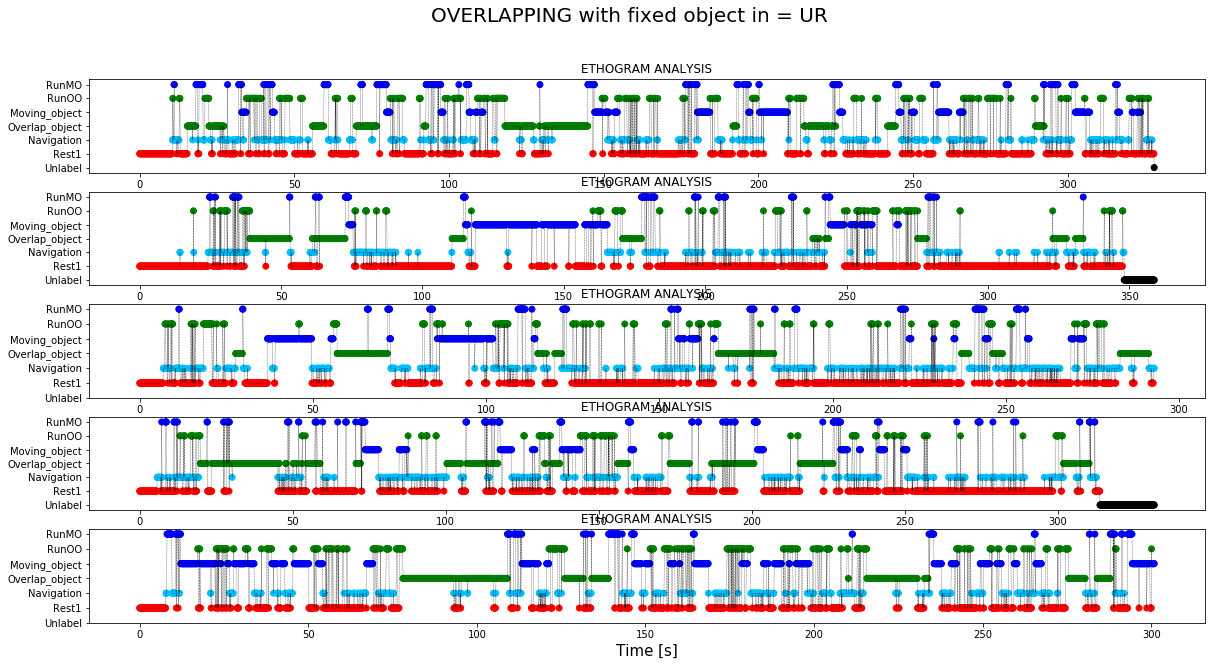

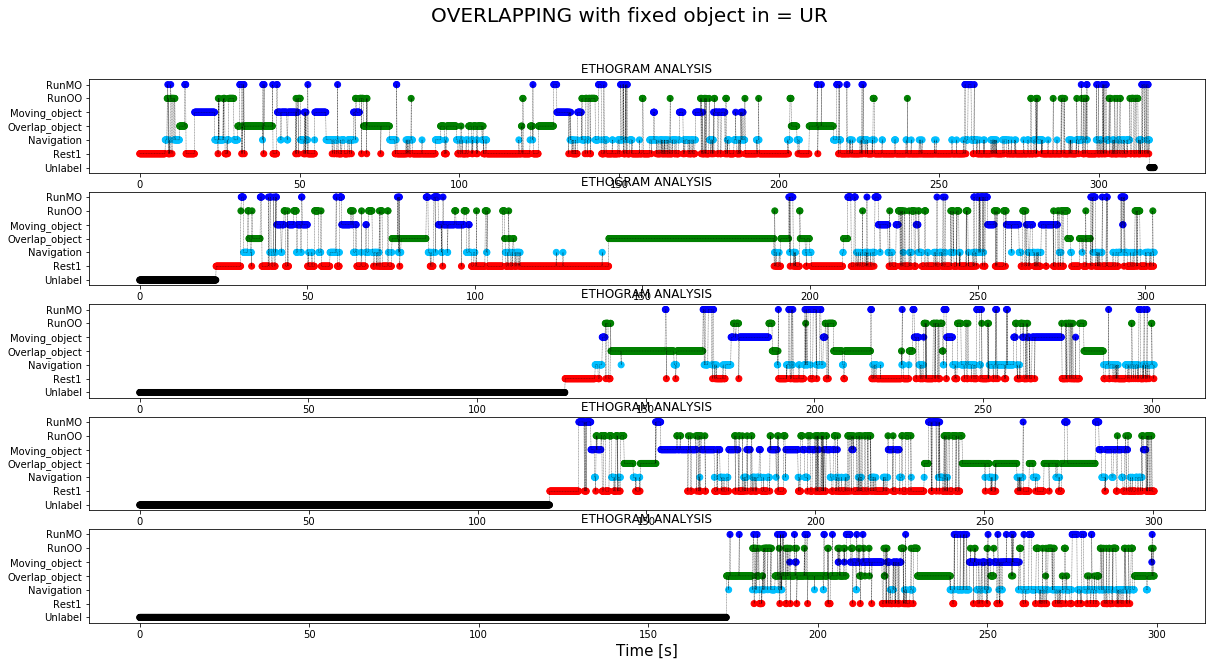

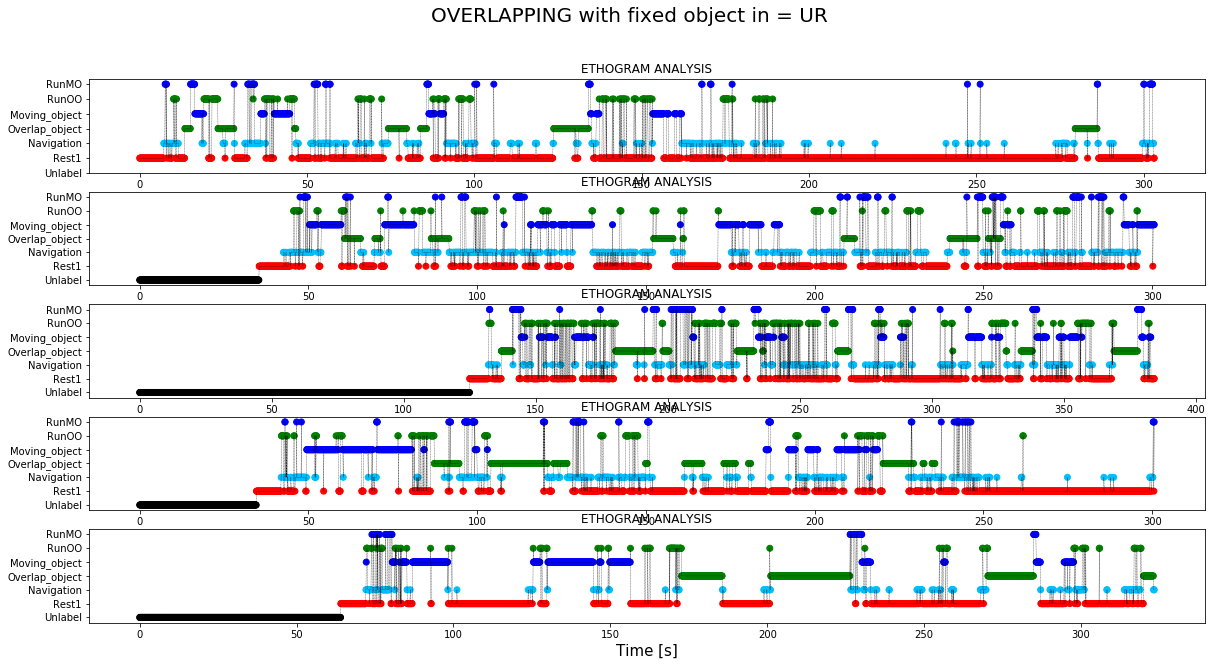

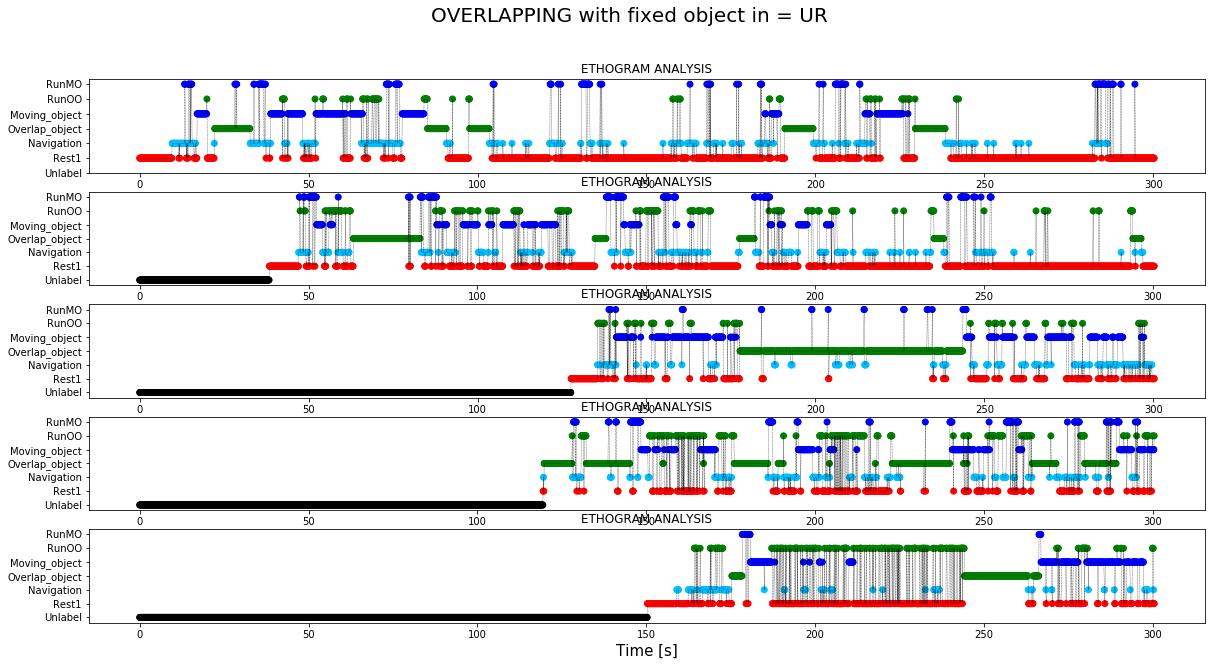

In [8]:

for day in range(len(behaviour)):

    figure = plt.figure(constrained_layout=True)
    gs = plt.GridSpec(5, 1)

    for trial in range(5):
        
        axes1 = figure.add_subplot(gs[trial, 0])
        behaviour_trial = behaviour[day][int(timeline_all[day][2*trial]):int(timeline_all[day][2*trial+1])]
        colors=[]
        for i in behaviour_trial:
            colors.append(colornames[int(i)])                                                                 
                                                                         
        axes1.scatter(np.arange(0,behaviour_trial.shape[0])/10,behaviour_trial,c=colors)
        axes1.plot(np.arange(0,behaviour_trial.shape[0])/10,behaviour_trial,linestyle="--",c="k",linewidth=0.3)
        axes1.set_yticks(np.arange(len(labels)))
        axes1.set_yticklabels(labels)
        axes1.set_xlabel('Time [s]', fontsize = 15)
        #axes1.set_xlim([0,len(behavioural_matrix[day])/10])
        #axes1.set_ylabel('Behavioural Condition', fontsize = 12)
        axes1.set_title('ETHOGRAM ANALYSIS')

    figure.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
    figure.set_size_inches(20,10)
    figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}'+'_day_'+f'{day+1}' + '_event_' + f'{re_sf}' + '_ethogram.png'
    figure.savefig(figure_path + figure_name)

In [9]:
behaviour_all = np.zeros((total_time,1))
start = 0
for day in range(len(behaviour)):
    behaviour_all[start:start+behaviour[day].shape[0]] = behaviour[day]
    start = start + behaviour[day].shape[0]

In [10]:
    
#time spent in an object
behavioural_matrix = np.zeros((len(id_target),40))
for day in range(len(behaviour)):
    for trial_it in range(5):
        trial = 2*(day*5 + trial_it)
        short_vector = behaviour_all[int(timeline_complete[trial]):int(timeline_complete[trial+1])]
        for target in id_target:
            position_events = np.where(short_vector == target)[0]
            behavioural_matrix[target,trial] = len(position_events)/short_vector.shape[0]

#number of visits
behavioural_number = np.zeros((len(id_target),40))
for day in range(len(behaviour)):
    for trial_it in range(5):
        trial = 2*(day*5+ trial_it)
        short_vector = behaviour_all[int(timeline_complete[trial]):int(timeline_complete[trial+1])]
        events_list = []
        events_counter_list = []
        start_counter = 100
        counter = 0
        for i in range(len(short_vector)):
            if short_vector[i] != start_counter:
                events_list.append(start_counter)
                events_counter_list.append(counter)
                start_counter = short_vector[i]
                counter = 1
            else:
                counter = counter + 1
        events = np.array(events_list)
        events_counter = np.array(events_counter_list)           #counter in frames un the original sampling rate
        for target in id_target:
            position_events = np.where(events == target)[0]
            behavioural_number[target,trial] = len(position_events)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


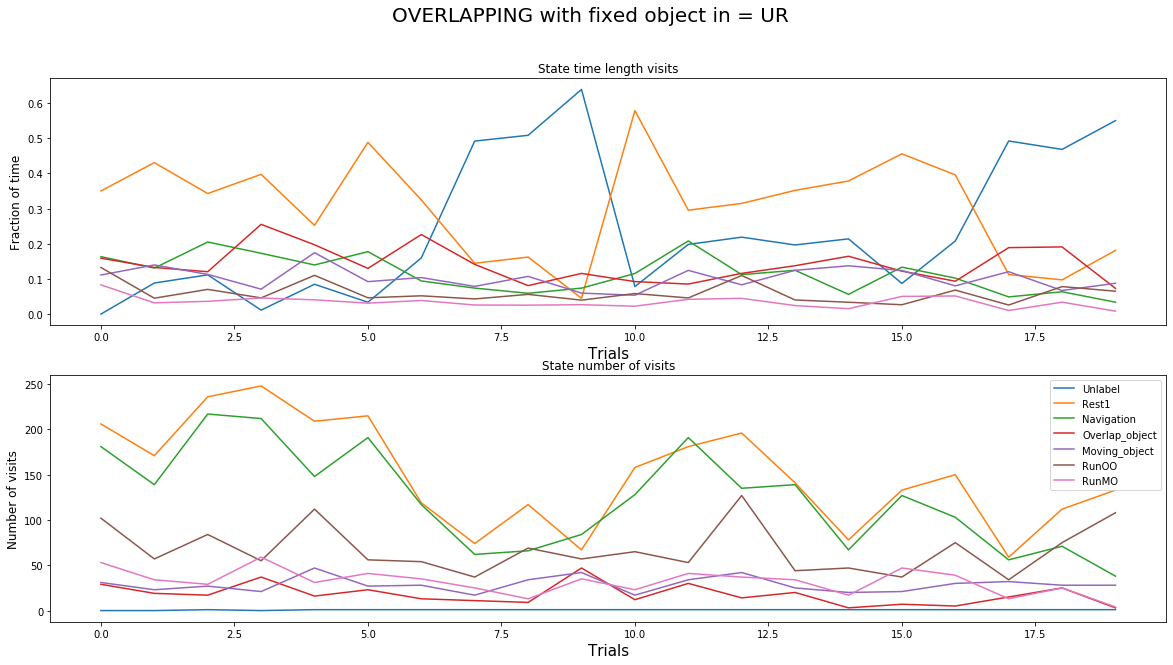

In [11]:
figure = plt.figure(constrained_layout=True)
gs = plt.GridSpec(2, 1)

axes2 = figure.add_subplot(gs[0, 0])
#x = axes2.imshow(behavioural_matrix)
axes2.plot(behavioural_matrix.T[np.arange(0,behavioural_matrix.shape[1],2)])
#axes2.set_yticks(np.arange(len(conditions)))
#axes2.set_yticklabels(conditions)
axes2.set_xlabel('Trials', fontsize = 15)
axes2.set_ylabel('Fraction of time', fontsize = 12)
#axes2.set_title('State Time')
#axes2.set_xlim([0,time_lenght])
axes2.set_title('State time length visits')


#figure.colorbar(x, ax =axes2)

axes3 = figure.add_subplot(gs[1, 0])
axes3.plot(behavioural_number.T[np.arange(0,behavioural_matrix.shape[1],2)])
#axes3.set_yticks(np.arange(len(conditions)))
#axes3.set_yticklabels(conditions)
axes3.set_xlabel('Trials', fontsize = 15)
axes3.set_ylabel('Number of visits', fontsize = 12)
axes3.legend(labels)
#axes3.set_xlim([0,time_lenght])
axes3.set_title('State number of visits')


#figure.colorbar(x, ax = axes3)

#figure.colorbar(x, ax =[axes1,axes2,axes3])
figure.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
figure.set_size_inches(20,10)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_exploration.png'
figure.savefig(figure_path + figure_name)

### Compute events visits statistics

In [12]:
# create vector with visits
events_list = []
events_counter_list = []
event_time = []
start_counter = 100
counter = 0
for i in range(len(behaviour_all)):
    if behaviour_all[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        event_time.append(i)
        start_counter = behaviour_all[i]
        counter = 1
    else:
        counter = counter + 1
        
events = np.array(events_list)
events_counter = np.array(events_counter_list) #counter in frames un the original sampling rate
event_time = np.array(event_time)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  app.launch_new_instance()


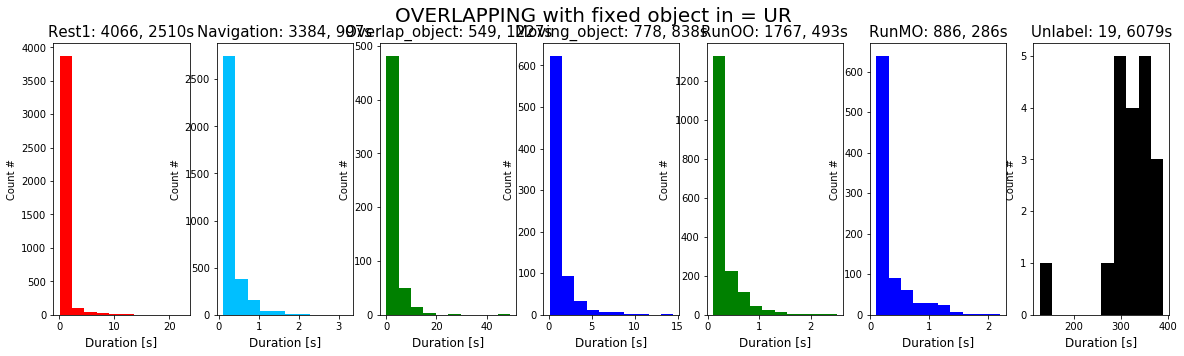

In [13]:
fig = plt.figure(constrained_layout=True)
gs = plt.GridSpec(1, len(id_target))
events = np.array(events_list)
events_counter = np.array(events_counter_list)           #counter in frames un the original sampling rate
for target in id_target:
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]/10   # convert to seconds
    ax = fig.add_subplot(gs[0, target-1])
    ax.hist(events_duration, color = colornames[target])
    ax.set_title(labels[target] +': '+ f'{len(position_events)}' +', ' + f'{int(sum(events_duration))}' + 's' ,fontsize = 15)
    ax.set_xlabel('Duration [s]',fontsize = 12)
    ax.set_ylabel('Count #')
fig.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
fig.set_size_inches(20, 5)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_exploratory_statistics.png'
fig.savefig(figure_path + figure_name)

### Duration statistics

### Compute transition matrix

In [15]:
### compute transition matrix from event_list vector
transition_matrix_events = np.zeros((len(id_target)-1,len(id_target)-1))
for i in range(len(id_target)-1):
    for j in range(len(id_target)-1):
        for k in range(len(events_list)-1):
            if events_list[k] == i+1 and events_list[k+1] == j+1:
                transition_matrix_events[i,j] = transition_matrix_events[i,j]+1
                
for i in range(len(id_target)-1):
    transition_matrix_events[i,:] = transition_matrix_events[i,:]/sum(transition_matrix_events[i,:])
                
### compute transition matrix from behaviour vector
transition_matrix = np.zeros((len(id_target)-1,len(id_target)-1))
relevant_index = np.where(behaviour_all)[0]
relevant_data = behaviour_all[relevant_index]
for i in range(len(id_target)-1):
    for j in range(len(id_target)-1):
        for k in range(relevant_data.shape[0]-1):
            if relevant_data[k] == i+1 and relevant_data[k+1] == j+1:
                transition_matrix[i,j] = transition_matrix[i,j]+1

norm_transition_matrix = transition_matrix
for i in range(len(id_target)-1):
    norm_transition_matrix[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])
    #norm_transition_matrix[i,i] = 0 
               

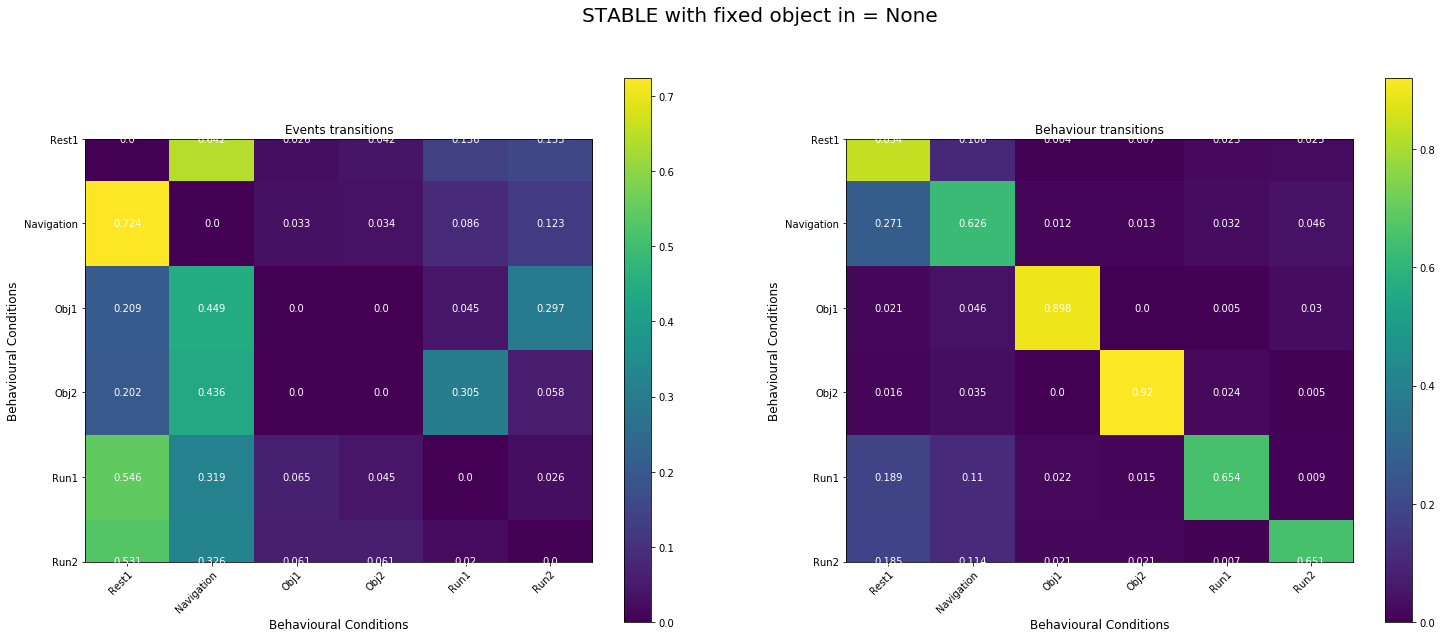

In [16]:
fig , axes = plt.subplots(1,2)
x = axes[0].imshow(transition_matrix_events)

x_pos = np.arange(len(labels)-1)
axes[0].set_title('Events transitions',fontsize = 12)
axes[0].set_ylabel('Behavioural Conditions', fontsize = 12)
axes[0].set_xlabel('Behavioural Conditions', fontsize = 12)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels[1:])
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(labels[1:])
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.setp(axes[0].get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

for i in range(len(labels)-1):
    for j in range(len(labels)-1):
        text = axes[0].text(j, i, round(transition_matrix_events[i, j],3),
                       ha="center", va="center", color="w")        
fig.colorbar(x, ax = axes[0])


x = axes[1].imshow(norm_transition_matrix)
x_pos = np.arange(len(labels)-1)
axes[1].set_title('Behaviour transitions',fontsize = 12)
axes[1].set_ylabel('Behavioural Conditions', fontsize = 12)
axes[1].set_xlabel('Behavioural Conditions', fontsize = 12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels[1:])
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(labels[1:])
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.setp(axes[1].get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

for i in range(len(labels)-1):
    for j in range(len(labels)-1):
        text = axes[1].text(j, i, round(norm_transition_matrix[i, j],3),
                       ha="center", va="center", color="w")        
fig.colorbar(x, ax = axes[1])


fig.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
fig.set_size_inches(25, 10)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_transition_matrix.png'
fig.savefig(figure_path + figure_name)

### Return Time

In [17]:
return_time = []
for target in id_target:
    visit_id = np.where(events == target)[0]
    visit_time = event_time[visit_id]
    visit_return_time = np.diff(visit_time)
    return_time.append(visit_return_time/10)

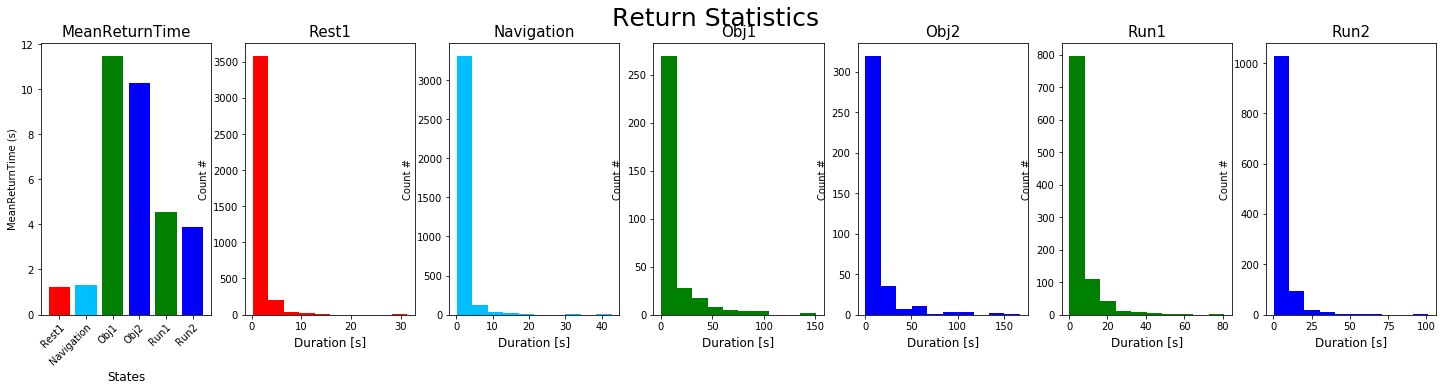

In [18]:
fig , axes = plt.subplots(1,len(id_target))

mean_return = []
for target in [1,2,3,4,5,6]:
    real_return = return_time[target][np.where(return_time[target]<200)[0]]
    axes[target].hist(real_return,color = colornames[target])
    axes[target].set_title(labels[target] ,fontsize = 15)
    axes[target].set_xlabel('Duration [s]',fontsize = 12)
    axes[target].set_ylabel('Count #')
    mean_return.append(np.mean(real_return))

axes[0].bar(np.arange(1,7,1),np.array(mean_return), color = colornames[1:])
axes[0].set_title('MeanReturnTime' ,fontsize = 15)
axes[0].set_xlabel('States',fontsize = 12)
axes[0].set_ylabel('MeanReturnTime (s)')   

x_pos = np.arange(1,7,1)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels[1:])
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fig.set_size_inches(25, 5)
fig.suptitle('Return Statistics', fontsize = 25)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_return_statistics.png'
fig.savefig(figure_path + figure_name)

### Memory effect (markovian or non-markovian behaviour)

In [19]:
NTM = transition_matrix.copy()
for i in range(len(id_target)-1):
    NTM[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])

In [20]:
TIME = 1000
initM = NTM
ps=np.zeros((NTM.shape[1],TIME))
for tau in range(TIME):
    for i in range(NTM.shape[1]):
        ps[i][tau]=initM[i][i]
    initM=np.matmul(initM,NTM)


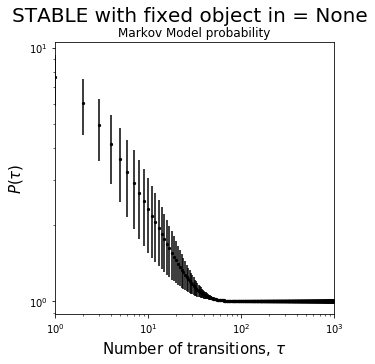

In [21]:
from scipy.stats import sem
figure, axes = plt.subplots(1)
ps1=ps.copy()
for i in range(len(ps)):
    ps1[i]=ps[i]/ps[i][-1]    
meanp=np.mean(ps1,axis=0)
stdp=sem(ps1,axis=0)

axes.scatter(np.arange(1,TIME+1),meanp,c='k',s=5)
axes.errorbar(np.arange(1,TIME+1),meanp,yerr=stdp, linestyle='None',c='k')
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlabel(r'Number of transitions, $\tau$ ',fontsize = 15)
axes.set_ylabel(r"$P(\tau)$",fontsize = 15)
axes.set_xlim([1,1000])
axes.set_title('Markov Model probability')

figure.suptitle(task + ' with fixed object in = ' + fixed, fontsize = 20)
figure.set_size_inches(5, 5)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_MCMC_return.png'
figure.savefig(figure_path + figure_name)

In [22]:
## experimental returns

prob_tau = np.zeros((len(id_target),TIME))
for target in id_target:
    tau = np.where(behaviour_all == target)[0]
    diff_matrix = np.zeros((tau.shape[0],TIME))
    for i in range(tau.shape[0]-TIME):
        for j in range(TIME):
            diff_matrix[i,j] = tau[i+j] - tau[i]
    diff_tau = np.reshape(diff_matrix,[tau.shape[0]*TIME,1])
    for i in range(TIME):
        counter = np.where(diff_tau == i)[0]
        prob_tau[target,i] = counter.shape[0] / tau.shape[0]

In [23]:
print(diff_tau.shape)

(3369000, 1)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


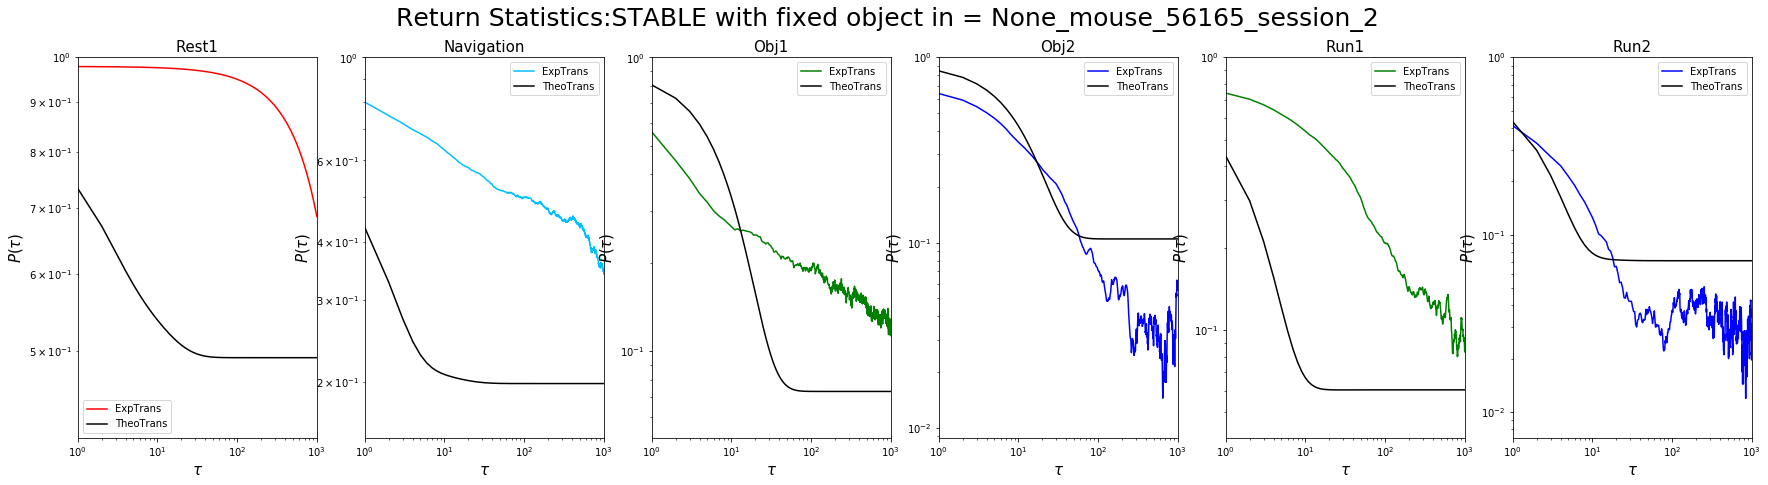

In [24]:
fig , axes = plt.subplots(1,len(id_target)-1)

for target in [1,2,3,4,5,6]:
    axes[target-1].plot(prob_tau[target-1,:],color = colornames[target])
    axes[target-1].plot(ps[target-1,:],'k')
    axes[target-1].set_xscale("log")
    axes[target-1].set_yscale("log")
    axes[target-1].set_title(labels[target] ,fontsize = 15)
    axes[target-1].set_xlabel(r'$\tau$ ',fontsize = 15)
    axes[target-1].set_ylabel(r"$P(\tau)$",fontsize = 15)   
    axes[target-1].set_xlim([1,1000])
    axes[target-1].set_ylim([0,1])
    axes[target-1].legend(['ExpTrans','TheoTrans'])
    
fig.set_size_inches(30, 7)
fig.suptitle('Return Statistics:' + task + ' with fixed object in = ' + fixed + '_mouse_' + f'{mouse}' + '_session_' + f'{session}' , fontsize = 25)
figure_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '_compare_MC_return.png'
fig.savefig(figure_path + figure_name)